# Note

Session 2 ended before Tasks 4, 6 & 7 were completed. Feedback that we got:

- Use the code in this notebook to produce new, different database files.
- Use target encoding for "native-country" instead of one-hot encoding (you will see that the result has many less columns).
- Never use the whole adult dataset, only the first 5000 entries.
- Regarding Task 7, it is easy to guess which features are important (an appropriate graph could confirm our suspicions e.g. age, gender, ...).
- The missing steps can be redone in the final report

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats.mstats import winsorize
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
db = pd.read_csv('data/adult.csv')
df = pd.DataFrame(db)

# Task 1

>Check for missing values in the dataset and handle them \[...\]

>Check the dataset for noisy data, inconsistencies, and duplicate entries \[...\].

## 1.1. Checking for missing values and handling them

#### Counting the missing values

There are missing values in the form of question marks ("?").

Let us [count](https://stackoverflow.com/questions/20076195/) these missing values.

In [2]:
# Stack all values and count the question marks
column_names = ["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
df[[i for i in column_names]].astype('str').stack().value_counts()['?'].sum()

707

#### Counting the Null values

As seen above, there are 707 missing values in total.

Let us count the null values (if any):

In [3]:
# Check for null values
df.isnull().sum().sum()

0

#### Listing the affected columns (variables)

So there are no null values.

As for the 707 missing values found earlier, we need to know how to impute them. Let us [find](https://stackoverflow.com/questions/50923707) the columns that contain missing values.

In [4]:
# List the columns that contain a question mark value
df.columns[df.isin(['?']).any()]

Index(['workclass', 'occupation', 'native-country'], dtype='object')

#### Determining their most frequent category

The 707 missing values are distributed over three variables. All three of these are nominal variables.

For now, we will impute them using the most frequent category. Since the 707 missing values are distributed over a total of 5'000x3 = 15'000 values, this simple imputation method should not significantly affect the data.

Let us first find out the most frequent category in each variable.

In [5]:
# Count most frequent value in "workclass"
df.workclass.value_counts().head(1)

workclass
Private    3420
Name: count, dtype: int64

In [6]:
# Count most frequent value in "occupation"
df.occupation.value_counts().head(1)

occupation
Prof-specialty    644
Name: count, dtype: int64

In [7]:
# Count most frequent value in "native-country"
df['native-country'].value_counts().head(1)

native-country
United-States    4514
Name: count, dtype: int64

#### Imputing with their most frequent category

Now we know that the most frequent categories are the Private sector, the "Prof-specialty" occupation, and the country United States.

Let us replace the missing values with the respective most frequent category.

In [8]:
# Workclass : Replace question marks
df.workclass.replace('?','Private', inplace=True)
# Count most frequent value again
df.workclass.value_counts().head(1)

workclass
Private    3735
Name: count, dtype: int64

In [9]:
# Occupation : Replace question marks
df.occupation.replace('?','Prof-specialty', inplace=True)
# Count most frequent value again
df.occupation.value_counts().head(1)

occupation
Prof-specialty    959
Name: count, dtype: int64

In [10]:
# Native-country : Replace question marks
df['native-country'].replace('?','United-States', inplace=True)
# Count most frequent value again
df['native-country'].value_counts().head(1)

native-country
United-States    4591
Name: count, dtype: int64

#### Checking that the missing values are handled

As expected, the most frequent categories became even more frequent. Let us check for missing values again.

In [11]:
# List the columns that contain a question mark value
df.columns[df.isin(['?']).any()]

Index([], dtype='object')

## 1.2. Checking for noisy data, inconsistencies & duplicate entries

### 1.2.1 Checking for noisy data

Some definitions for noisy data include: Data that is corrupted/distorted & Data that has a low signal-to-noise ratio.

While the latter can be [measured using a formula](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), checking for corrupted and distorted data will need manual examination.

#### Finding corrupted data

[There are 8 nominal variables in our data.](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html) Corrupted values are likely to hide in their rarest categories.

Let us search for corrupted data, by listing rare categories in non-number variables, treating "native-country" separately since it has especially many categories.

In [12]:
# Stack values in said non-number variables and show the rarest categories
non_num_column_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']
df[[i for i in non_num_column_names]].astype('str').stack().value_counts().tail()

1st-4th              24
Preschool            13
Married-AF-spouse     3
Without-pay           2
Armed-Forces          1
Name: count, dtype: int64

In [13]:
# Stack values in "native-country" and show the rarest categories
df[['native-country']].astype('str').stack().value_counts().tail()

Laos                          1
Hong                          1
Trinadad&Tobago               1
Outlying-US(Guam-USVI-etc)    1
France                        1
Name: count, dtype: int64

Examining these values reveals no corrupted information except for typing errors in the country names of Hong Kong and Trinidad&Tobago. However, the typing errors do not affect the usefulness of the data, as each country is represented by only one category.

#### Finding distorted data

[Our data has 6 continous variables.](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html) They are "age", "fnlwgt" (finalweight), "educational-num", "capital-gain", "capital-loss", and "hours-per-week". For the first five, there exists a distribution plot in our first presentation. As for "hours-per-week", a plot has been generated below.

Considering all of these plots, there is only one obvious distortion: Age 90 is more represented than the other ages in that range. We assume that this is an intended grouping of ages 90+ that has been made in the original data. Therefore it does not negatively affect the quality of the dataset

<Axes: ylabel='Frequency'>

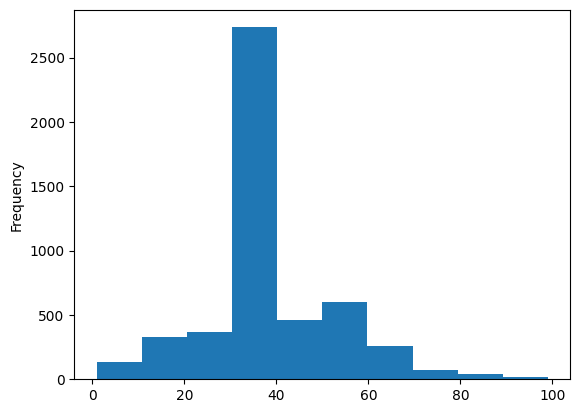

In [14]:
# Value distribution plot for "hours-per-week" (requires matplotlib)
df['hours-per-week'].plot.hist()

#### Measuring noise in numeric variables

We will measure the signal-to-noise ratio (SNR) of the 6 numeric variables to determine if any has a high noise.

According to [this Wikipedia article](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), the SNR can be calculated as (μ^2/σ^2).

Let us find μ (the means) and σ (the standard deviations) to apply the formula.

In [15]:
# Get mean and STD of the the numerical variables
numericInfo = df.describe().iloc[1:3]
numericInfo

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
mean,38.504800,187269.876000,10.038400,1107.090200,89.561400,40.20600
std,13.779781,102781.411899,2.595433,7708.019951,408.651437,12.45805


Now, let us compute the SNR.

In [16]:
# Calculate SNRs and store them in variables
resultage = ( (numericInfo['age'][0])**2 ) / ( (numericInfo['age'][1])**2 )
resultweight = ( (numericInfo['fnlwgt'][0])**2 ) / ( (numericInfo['fnlwgt'][1])**2 )
resultedu = ( (numericInfo['educational-num'][0])**2 ) / ( (numericInfo['educational-num'][1])**2 )
resultcapg = ( (numericInfo['capital-gain'][0])**2 ) / ( (numericInfo['capital-gain'][1])**2 )
resultcapl = ( (numericInfo['capital-loss'][0])**2 ) / ( (numericInfo['capital-loss'][1])**2 )
resulthpw = ( (numericInfo['hours-per-week'][0])**2 ) / ( (numericInfo['hours-per-week'][1])**2 )
# Output the variables
def SNRs():
    return {"Age": resultage, "Final Weight": resultweight, "Education-Num": resultedu, "Capital Gain": resultcapg, "Capital Loss": resultcapl, "Hours per Week": resulthpw}
SNRs()

{'Age': 7.8080958880742415,
 'Final Weight': 3.319759996517732,
 'Education-Num': 14.959233262883458,
 'Capital Gain': 0.02062910339656595,
 'Capital Loss': 0.04803255474767841,
 'Hours per Week': 10.415535705359764}

As we can see, the signal is significantly stronger than the noise for most variables. However, the two variables "capital-gain" and "capital-loss" have a very weak SNR.

The high noise in the capital related data might make its analysis difficult. Feature Engineering might be a solution to make more useful data from "capital-gain" and "capital-loss".

### 1.2.2 Checking for inconsistencies

Let us make sure Capital Gains VS Losses are mutually exclusive.

In [17]:
# Output entries with non-zero capital gains AND losses, if any
def capitalInconsistencies():
    inconsistent_data = df[(df['capital-gain'] > 0) & (df['capital-loss'] > 0)]
    if not inconsistent_data.empty:
        return inconsistent_data
    else:
        return "Empty Dataset"
capitalInconsistencies()

'Empty Dataset'

We note that there is no entry with capital gains AND losses.

### 1.2.3 Checking for duplicates

In [18]:
# Output entries that are identical, if any
def duplicatesInDf():
    duplicates = df[df.duplicated(keep=False)]
    if not duplicates.empty:
        return duplicates
    else:
        return "Empty Dataset"
duplicatesInDf()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
488,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K
864,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K


Seeing as there is one duplicate, let us drop it.

In [19]:
# Remove duplicates
df.drop_duplicates(inplace=True)
# Search for duplicates
duplicatesInDf()

'Empty Dataset'

In [20]:
# Make sure that there are still no missing values somehow
assert df.isnull().sum().sum() == 0
True

True

# Task 2

>[Convert categorical features to numerical values using encoding techniques]

**To avoid confusion: "categorical" = "nominal". We do not count the index column.**

## 2.1. Encoding education and income

#### Encoding education

As already mentioned in 1.2.1, there are 8 nominal variables. Education is already ordinally encoded, so let us drop the non-numerical variable.

In [21]:
# Remove variable "education"
df.drop(columns='education',inplace=True)

Note that **the number of columns has decreased from 15 to 14.**

#### Encoding income

The class of our dataset - "income" - only has two categories. We can simply apply binary encoding.

In [22]:
# Replace "income" value "<=50K" with 0, and "income" value ">50K" with 1
df['income'].replace('<=50K', 0, inplace=True)
df['income'].replace('>50K', 1, inplace=True)

## 2.2. Encoding the remaining categorical variables

There remain 13 columns that we need to consider:
1. We have 6 numerical features that we can ignore because they are already numerical
2. **We have 7 categorical features for which we will try one-hot-encoding**

NB: Due to the Feature Engineering in Task 6, there is one more categorical feature ("occupation-type") that is accounted for in the code below. However, the notes and the comments are from before this new feature was created.

#### One-hot-encoding

Since the remaining 7 nominal variables are not ordinal, we do not want to use e.g. label encoding, as that could introduce unintended biases. Instead, we will use One-Hot encoding for them.

Let us apply One-Hot Encoding.

In [25]:
# Select the 7 nominal columns
categorical_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'occupation-type']
# Select the other 7 columns (6 numericals + "income")
numeric_cols = df.columns.difference(categorical_cols)
# Perform one-hot encoding on categorical columns
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_array = onehot_encoder.fit_transform(df[categorical_cols])
column_names = onehot_encoder.get_feature_names_out(categorical_cols)
onehot_df = pd.DataFrame(onehot_array, columns=column_names)
# Concatenate one-hot encoded DataFrame with original numerical and income columns
numeric_df = df[numeric_cols].reset_index(drop=True)
encoded_df = pd.concat([numeric_df, onehot_df], axis=1)
# Get snippet of the processed DataFrame
encoded_df.head(1)

,age,capital-gain,capital-loss,educational-num,fnlwgt,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,occupation-type_Professional,occupation-type_Service,occupation-type_Technical
0,25,0,0,7,226802,40,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


The increase in the number of columns from 14 to 87 indicates that there were 73 unique values across the 7 encoded categorical columns.

## 2.3. Changing the approach for "native-country"

Since the number of columns increased considerably after One-hot-encoding, we shall try it again. But this time, instead of using One-hot-encoding for "native-country" , we will apply target encoding. This way, the "native-country" variable will not inflate the number of columns.

Let us omit "native-country" from the One-hot-encoding.

In [26]:
# Repeat the One-hot-encoding of the 7 nominal columns (EXCEPT "native-country")
categorical_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'occupation-type']
numeric_cols = df.columns.difference(categorical_cols)
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_array = onehot_encoder.fit_transform(df[categorical_cols])
column_names = onehot_encoder.get_feature_names_out(categorical_cols)
onehot_df = pd.DataFrame(onehot_array, columns=column_names)
numeric_df = df[numeric_cols].reset_index(drop=True)
encoded_df = pd.concat([numeric_df, onehot_df], axis=1)
encoded_df.head(1)

,age,capital-gain,capital-loss,educational-num,fnlwgt,hours-per-week,income,native-country,workclass_Federal-gov,workclass_Local-gov,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,occupation-type_Professional,occupation-type_Service,occupation-type_Technical
0,25,0,0,7,226802,40,0,United-States,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


**Target-Encoding is problematic** due to target leakage. For instance, we plan to replace the native country with the average income for that country (the *mean of the target*). By doing that, we train a model with information that is directly related to what it should predict. 

We want to avoid that. Therefore [prior smoothing](https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69) is necessary. For this purpose, we can use the [Target Encoder from Category Encoders](https://contrib.scikit-learn.org/category_encoders/targetencoder.html).

Let us target-encode the remaining column "native-country", with an encoder that applies measures to prevent target leakage.

In [27]:
# Copy the one-hot-encoded database
df = encoded_df.copy()
# Target-Encode "native-country" and replace the original countries in the copy
target_encoder = TargetEncoder()
df['native-country'] = target_encoder.fit_transform(encoded_df['native-country'], encoded_df['income'])
# Print a snippet of the fully encoded copy
df.head(1)

,age,capital-gain,capital-loss,educational-num,fnlwgt,hours-per-week,income,native-country,workclass_Federal-gov,workclass_Local-gov,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,occupation-type_Professional,occupation-type_Service,occupation-type_Technical
0,25,0,0,7,226802,40,0,0.240741,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Task 3

>How can you scale the continuous features in your dataset? Consider using techniques such as min-max scaling and normalization.

**To avoid confusion: The "Scaling" methods showcased here are "Normalization" and "Standardization". The specific technique that we used for "Normalization" is called "Min-Max Scaling".**

In [28]:
# Select continuous columns
continuous_cols = ['age', 'capital-gain', 'capital-loss', 'educational-num', 'fnlwgt', 'hours-per-week']

#### Min-Max Scaling

We use Min-Max Scaling because it is the usual method of Normalization: ["Normalization typically means rescales the values into a range of [0,1]"](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf).

Let us apply Min-Max Scaling to the continuous variables.

In [29]:
# Perform min-max scaling
min_max_scaler = MinMaxScaler()
minmax_df = df.copy()
minmax_df[continuous_cols] = min_max_scaler.fit_transform(minmax_df[continuous_cols])

#### Standardization

["Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance)."](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)

Let us try Standardization instead.

In [30]:
# Perform standardization
standard_scaler = StandardScaler()
standard_df = df.copy()
standard_df[continuous_cols] = standard_scaler.fit_transform(standard_df[continuous_cols])

#### Comparing scaling methods

We have tried 3 different scaling methods: (1) Not scaling at all, (2) Min-Max Scaling & (3) Standardization.

Without an ML model, we cannot compare their use. However, we can already confirm the following suspicions:

1. Without Scaling, the range of values widely varies
2. With Min-Max Scaling, the continous variables are reduced to the same range as the encoded categorical variables
3. With Standardization, we introduce the first negative values to the dataset

Let us visualize the differently scaled datasets.

<Axes: >

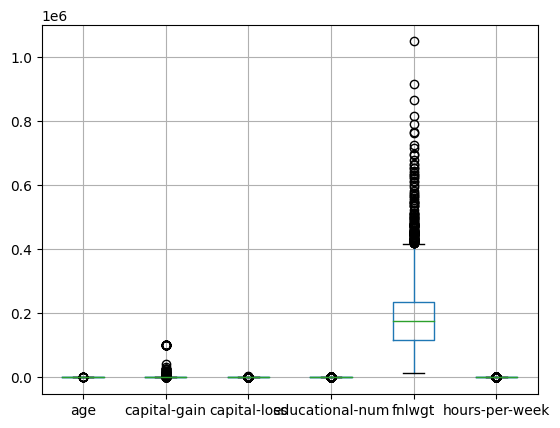

In [31]:
# Boxplot the continuous features in processed_df
df[continuous_cols].boxplot()

<Axes: >

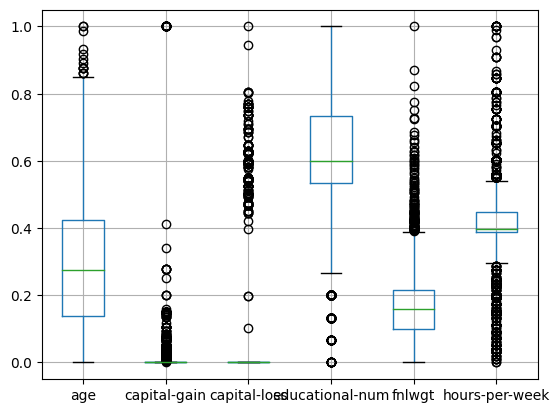

In [32]:
# Boxplot the continuous features in minmax_df
minmax_df[continuous_cols].boxplot()

<Axes: >

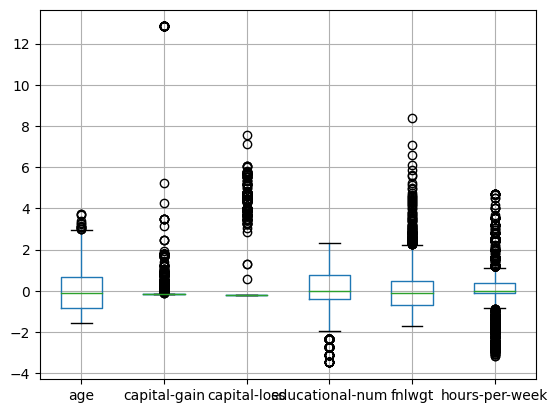

In [33]:
# Boxplot the continuous features in standard_df
standard_df[continuous_cols].boxplot()

In [34]:
df_vals = df.to_numpy()
minmax_vals = minmax_df.to_numpy()
standard_vals = standard_df.to_numpy()
print("Bounds in unscaled dataset: ", df_vals.min(), "-", df_vals.max())
print("Bounds in normalized dataset: ", minmax_vals.min(), "-", minmax_vals.max())
print("Bounds in standardized dataset: ", standard_vals.min(), "-", standard_vals.max())

Bounds in unscaled dataset:  0.0 - 1047822.0
Bounds in normalized dataset:  0.0 - 1.0
Bounds in standardized dataset:  -3.4826500572282546 - 12.829740070056708


# Task 4

>Check for outliers in the dataset features and handle them using appropriate techniques like removing outliers, imputation, winsorization, transformation, and bin binning.

We have seen above that there are many outliers. They can "[have a significant impact on conclusions](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755)" (A. Horsch). For Subtasks 4.1. and 4.2., we will cite Horsch and her articles unless otherwise linked.

According to Horsch, there are 3 main ways of handling outliers:
1. Keep
2. Delete
3. Recode

We will **keep** the original values of "fnlwgt". There is no good reason to manipulate the weights of entries.

We will not **delete** any entries. Deleting entries is not recommended when there are many outliers.

Hence we will **recode** the remaining 5 continuous variables.

## 4.1. Deciding on the appropriate technique

### 4.1.1 Identifying inappropriate techniques

#### Imputation.

Imputation is often used to replace outliers with a reasonable estimate. However, it works best with so-called Multiple Imputation, which is more complicated to implement in Python than in R (allegedly). Moreover, for our case, Imputation has no obvious advantage over Winsorization.

#### Log Transformation.

Log Transformation is "[preferred when a variable grows or decays on an exponential scale](https://towardsdatascience.com/dont-throw-away-your-outliers-c37e1ab0ce19)", which our variables do not.

### 4.1.2 Identifying appropriate techniques

#### Winsorization

Winsorization is also known as "capping". For most variables, it seems appropriate.

Horsch recommends to use a Winsorization level close to the Outer Fence of a variable "to keep as much data as possible".

#### Binning

Binning effectively groups continuous variables into a smaller number of possible values. We can apply Binning to the "age" variable, since we plan to create age groups anyway.

## 4.2. Winsorizing

### 4.2.1 Finding the outer fences

Please note that some of the following code is from [one of Horsch's articles](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0).

Let us find the lower outer fence (LOF) and upper outer fence (UOF) of "capital-gain", "capital-loss", "educational-num" and "hours-per-week".

In [35]:
# Define function that ouputs LOF and UOF
def fences(df, variable_name):    
    q1 = df[variable_name].quantile(0.25)
    q3 = df[variable_name].quantile(0.75)
    iqr = q3-q1
    OF = 3*iqr
    LOF = q1-OF
    UOF = q3+OF
    return LOF, UOF

#### Outer fences of hours-per-week

In [36]:
HPWLOF, HPWUOF = fences(df, 'hours-per-week')
print("Outer fences of hours-per-week")
print()
print("Lower outer fence: ", HPWLOF)
print("Upper end outer fence: ", HPWUOF)

Outer fences of hours-per-week

Lower outer fence:  21.0
Upper end outer fence:  63.0


Apparently, putting the Winsorization Level to the outer fences would make sense for the "hours-per-week" variable.

#### Outer fences of educational-num

In [37]:
ENLOF, ENUOF = fences(df, 'educational-num')
print("Outer fences of educational-num")
print()
print("Lower outer fence: ", ENLOF)
print("Upper end outer fence: ", ENUOF)

Outer fences of educational-num

Lower outer fence:  0.0
Upper end outer fence:  21.0


As for "educational-num", the outliers do not need to removed; They are within the outer fences and thus mild outliers.

#### Outer fences of the two "capital" variables

In [38]:
CGLOF, CGUOF = fences(df, 'capital-gain')
print("Outer fences of capital-gain")
print()
print("Lower outer fence: ", CGLOF)
print("Upper end outer fence: ", CGUOF)

Outer fences of capital-gain

Lower outer fence:  0.0
Upper end outer fence:  0.0


In [39]:
CLLOF, CLUOF = fences(df, 'capital-loss')
print("Outer fences of capital-loss")
print()
print("Lower outer fence: ", CLLOF)
print("Upper end outer fence: ", CLUOF)

Outer fences of capital-loss

Lower outer fence:  0.0
Upper end outer fence:  0.0


The two variables related to capital have their outer fences at 0. Therefore a different approach is necessary.

We will consider how to handle the problematic "capital" variables in the Feature Engineering step.

### 4.2.2 Capping the Outliers

Recall that we apply Winsorization only to "hours-per-week". We shall use the 9th and the 97th percentile as the Winsorization Level since they approximately correspond to the outer fences.

Let us winsorize said variable.

In [40]:
# Make a copy
df_old = df.copy()
# Winsorize "hours-per-week"
df['hours-per-week'] = winsorize(df_old['hours-per-week'], limits=(0.09, 0.03))

Let us compare the statistics from before and after.

In [41]:
# Make a comparison table
dfCompare = pd.DataFrame()
dfCompare['old'] = df_old[['hours-per-week']]
dfCompare['new'] = df[['hours-per-week']]
dfCompare.describe()

,old,new
count,4999.000000,4999.000000
mean,40.207041,40.344069
std,12.459078,10.365743
min,1.000000,20.000000
25%,39.000000,39.000000
50%,40.000000,40.000000
75%,45.000000,45.000000
max,99.000000,65.000000


## 4.3. Binning

Recall that we apply Binning only to "age". We shall use binning with the custom edges defined in the instruction of Task 4.

NB: Instead of actually binning age, we will keep the original age feature and create a new variable for age groups. In this sense this step is more Feature Engineering than Outlier Handling.

### 4.3.1 Finding the Bin Edges

Please note that some of the following code is from [this article](https://towardsdatascience.com/data-preprocessing-with-python-pandas-part-5-binning-c5bd5fd1b950).

We will group ages into three bins. Let us compute the edges of our bins.

In [42]:
# Print age range and output 4 custom distanced values within the range
minAge = df['age'].min()
print(minAge)
maxAge = df['age'].max()
print(maxAge)
bins = [17, 25, 50, 90] # Edges
bins

17
90


[17, 25, 50, 90]

Now, we can effectively label-encode the age groups, which is appropriate because age groups have an implicit order.

Let us use the numeric labels 0, 1 and 2 for young, middle-aged and senior ages respectively.

In [43]:
# Define labels for the bins
labels = [0, 1, 2]

### 4.3.2 Creating the bins

Let us convert each age to its respective bin label. Let us also print the first three rows of the dataset before and after binning.

In [44]:
# Output the Dataframe without Bins
df.head()

,age,capital-gain,capital-loss,educational-num,fnlwgt,hours-per-week,income,native-country,workclass_Federal-gov,workclass_Local-gov,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,occupation-type_Professional,occupation-type_Service,occupation-type_Technical
0,25,0,0,7,226802,40,0,0.240741,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38,0,0,9,89814,50,0,0.240741,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,28,0,0,12,336951,40,1,0.240741,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,44,7688,0,10,160323,40,1,0.240741,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,18,0,0,10,103497,30,0,0.240741,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [45]:
# Use the bins to create age groups (This is the actual Binning step)
df['age-group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

In [46]:
# Output the current Dataframe
df.head()

,age,capital-gain,capital-loss,educational-num,fnlwgt,hours-per-week,income,native-country,workclass_Federal-gov,workclass_Local-gov,...,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,occupation-type_Professional,occupation-type_Service,occupation-type_Technical,age-group
0,25,0,0,7,226802,40,0,0.240741,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,38,0,0,9,89814,50,0,0.240741,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1
2,28,0,0,12,336951,40,1,0.240741,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1
3,44,7688,0,10,160323,40,1,0.240741,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
4,18,0,0,10,103497,30,0,0.240741,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0


# Task 5

>Analyse the dataset and determine if the target variable 'class' is balanced or not.

>[...] balance it using techniques [like under-sampling].

#### Determining if the dataset is balanced

First, we need to calculate the proportion of each class in the target variable. Let us count the number of occurrences of each class (<=50K and >50K) and calculate the percentage of each class.

In [47]:
income_counts = df['income'].value_counts()
income_percentage = df['income'].value_counts(normalize=True) * 100

print("Counts of each class:")
print(income_counts)
print("\nPercentage of each class:")
print(income_percentage)

Counts of each class:
income
0    3827
1    1172
Name: count, dtype: int64

Percentage of each class:
income
0    76.555311
1    23.444689
Name: proportion, dtype: float64


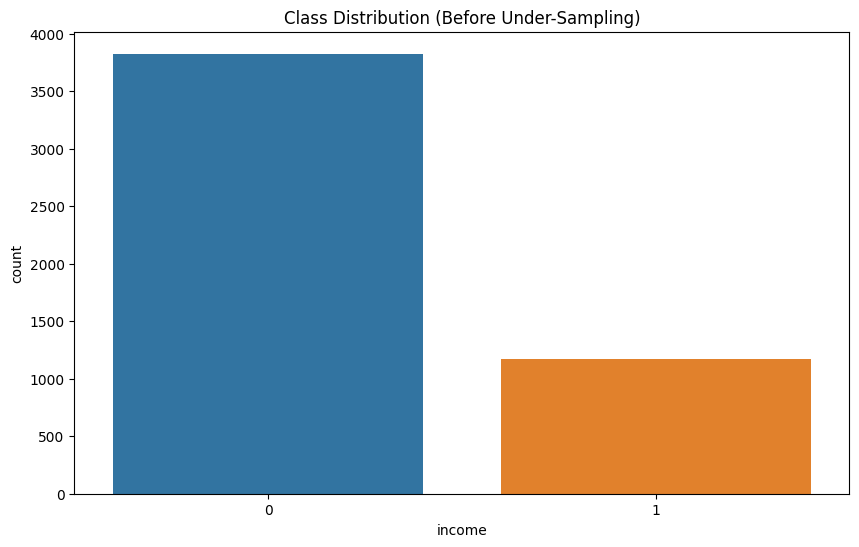

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x='income', data=df)
plt.title("Class Distribution (Before Under-Sampling)")
plt.show()

#### Undersampling the data

We chose random under-sampling because it's simple: Eliminating instances from the majority class. It's useful when the dataset is large enough for model performance to remain the same. NB: Random under-sampling can potentially remove important information from the majority class, especially when there is a high imbalance ratio.


Counts of each class after random under-sampling:
Counter({0: 1172, 1: 1172})


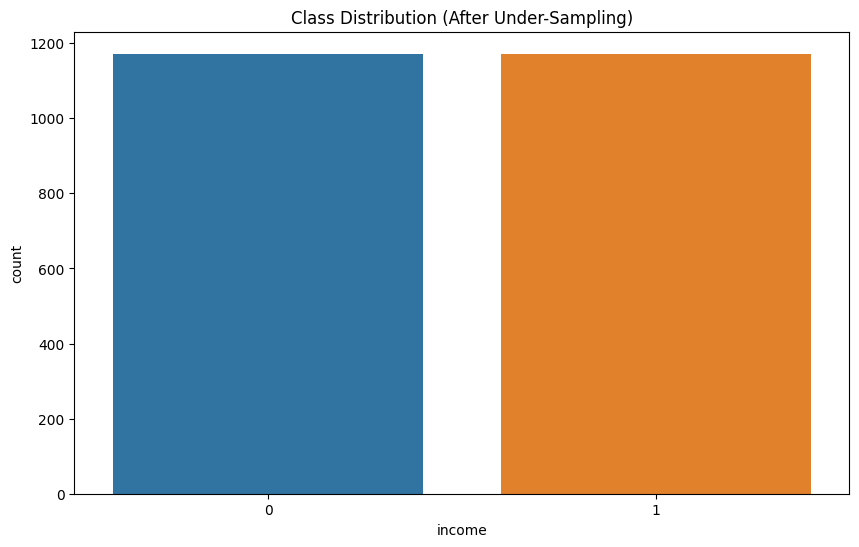

In [49]:
X = df.drop('income', axis=1)
y = df['income']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("\nCounts of each class after random under-sampling:")
print(Counter(y_resampled))

df = pd.concat([X_resampled, y_resampled], axis=1) # Resampled Data

plt.figure(figsize=(10, 6))
sns.countplot(x='income', data=df)
plt.title("Class Distribution (After Under-Sampling)")
plt.show()

# Task 6

>Analyse the dataset and create new features/derived features. [...] This can help the model better capture patterns.

We have 3 instances of Feature Engineering:
1. In Task 4 (Outlier Handling), we already binned age in a new variable "age-group".
2. We can further categorize "occupation" in a new variable "occupation-type".
3. We somehow need to address the two capital related variables, which exhibit a high noise.

## 6.2. Further categorizing occupation

We want to add a feature "occupation-type", which we also want to one-hot-encode.

So, let us create Occupation types before the One-hot-encoding step in the 2.2. Subtask.

In [23]:
# RUN THIS BEFORE THE ENCODING IN 2.2.
# Select rows of different occupation types and add according value in new feature 'occupation-type'
df.loc[df['occupation'].isin(['Prof-specialty', 'Exec-managerial', 'Adm-clerical', 'Farming-fishing', 'Armed-Forces']), 'occupation-type'] = 'Professional'
df.loc[df['occupation'].isin(['Craft-repair', 'Machine-op-inspct', 'Tech-support']), 'occupation-type'] = 'Technical'
df.loc[df['occupation'].isin(['Sales', 'Other-service', 'Transport-moving', 'Handlers-cleaners', 'Protective-serv', 'Priv-house-serv']), 'occupation-type'] = 'Service'

In [24]:
# Output pre-encoding dataframe
df

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,occupation-type
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0,Technical
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0,Professional
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1,Service
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1,Technical
4,18,Private,103497,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,0,Professional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,49,Private,141483,6,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,0,Professional
4996,35,Federal-gov,191480,13,Married-spouse-absent,Exec-managerial,Not-in-family,Black,Male,0,0,40,United-States,0,Professional
4997,40,Private,202466,9,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,60,United-States,0,Professional
4998,50,Private,28765,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1,Professional


## 6.1. Merging capital related features

We have shown that "capital-gain" and "capital-loss" are not very useful, nor easy to handle:
- They exhibit a high statistical noise
- They inflate our data with many unnecessary 0's (in those cases that have a gain or a loss)
- Most rows have no gain or loss, so those that do are automatically outliers

We choose an exteme approach: We merge the variables, bin their values to labels that mean "loss", "nothing", and "gain" respectively, and afterwards we delete the original two variables. This labeling retains the appropriate order, as well as the distinction between people with capital activity and those without.

This approach is extreme because, due to only using 3 bins, it is basically mass deletion of original data. For this reason, we will produce two preprocessed datasets: One that contains only the newly created feature as described above, and one that contains the new feature along with the two original features.

Let us create a new feature "capital" from "capital-gain" and "capital-loss". 

In [50]:
# Create "capital" as difference between gain and loss
df['capital'] = df['capital-gain'] - df['capital-loss']

Now, let us follow a simple approach as with Age Binning. Let loss = 0, nothing = 1, and gain = 2.

In [51]:
# Print capital range and the edges of the bins
minCap = df['capital'].min()
print(minCap)
maxCap = df['capital'].max()
print(maxCap)
binsCap = [minCap, -1, 1, maxCap]
print(binsCap)
# Use the bins to create capital groups
df['capital'] = pd.cut(df['capital'], bins=binsCap, labels=labels, include_lowest=True)

-3175
99999
[-3175, -1, 1, 99999]


Finally, let us remove "capital-gain" and "capital-loss".

In [52]:
# Remove variables "capital-gain" and "capital-loss"
df.drop(columns=['capital-gain', 'capital-loss'],inplace=True)
# Output sclice of Dataframe with "capital" feature binned and original variables removed
df.head()

,age,educational-num,fnlwgt,hours-per-week,native-country,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,race_Other,race_White,gender_Female,gender_Male,occupation-type_Professional,occupation-type_Service,occupation-type_Technical,age-group,income,capital
0,31,13,109195,65,0.240741,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,1
1,17,5,141445,20,0.240741,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0,1
2,44,10,114753,38,0.240741,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0,1
3,32,9,339196,40,0.240741,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,1
4,45,3,123219,40,0.240741,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,1


In [53]:
df[['capital']].value_counts()

capital
1          1892
2           301
0           151
Name: count, dtype: int64

<h1><span style="color:red">Task 7</span></h1>

>Identify:

>[1.] The relevant features that are likely to have a significant impact [on income]

>[2.] The irrelevant or redundant features [...] to the prediction task.